In [64]:
import pandas as pd
import numpy as np

train = pd.read_csv("./input/processed_train_logged.csv")
test = pd.read_csv("./input/processed_test_logged.csv")
#all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
#                      test.loc[:, 'MSSubClass':'SaleCondition']))

In [65]:
train.head()
#处理输入数据
target = 'label'
feat_data = train[train.columns[train.columns!='label']]
feat_names = feat_data.dtypes[feat_data.dtypes!=object].index
feat_names = [item for item in feat_names if item!='Id']
X_train= train[feat_names].values
y_train = train['label'].values
X_test = test[feat_names].values

In [66]:
# numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
# all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())
#                                                             / (x.std()))

In [67]:
# all_X = pd.get_dummies(all_X, dummy_na=True)

In [68]:
# all_X = all_X.fillna(all_X.mean())

In [69]:
# num_train = train.shape[0]

# X_train = all_X[:num_train].as_matrix()
# X_test = all_X[num_train:].as_matrix()
# y_train = train.SalePrice.as_matrix()

num_train = train.shape[0]


In [70]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

In [71]:
square_loss = gluon.loss.L2Loss()

In [72]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [73]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [74]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs, 
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:    
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [75]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [82]:
k = 5
epochs = 100
verbose_epoch = 95
learning_rate = 0.05
weight_decay = 1

Epoch 96, train loss: 0.082052
Epoch 97, train loss: 0.082805
Epoch 98, train loss: 0.094416
Epoch 99, train loss: 0.082032


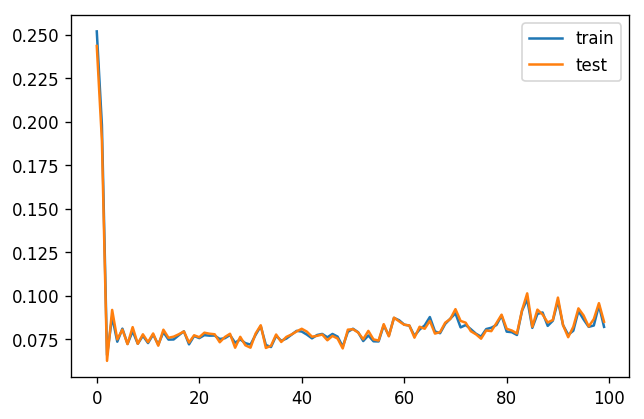

Test loss: 0.084947
Epoch 96, train loss: 0.083077
Epoch 97, train loss: 0.084546
Epoch 98, train loss: 0.079241
Epoch 99, train loss: 0.077676


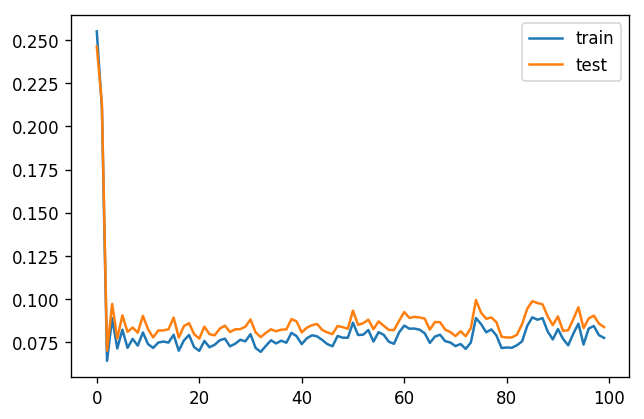

Test loss: 0.083910
Epoch 96, train loss: 0.072628
Epoch 97, train loss: 0.085246
Epoch 98, train loss: 0.075319
Epoch 99, train loss: 0.073647


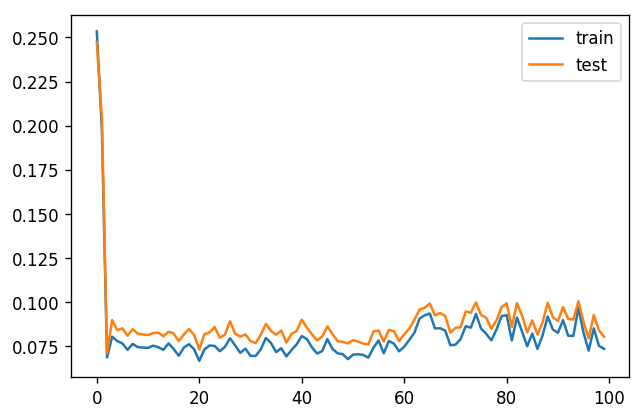

Test loss: 0.080545
Epoch 96, train loss: 0.089928
Epoch 97, train loss: 0.087012
Epoch 98, train loss: 0.068929
Epoch 99, train loss: 0.096256


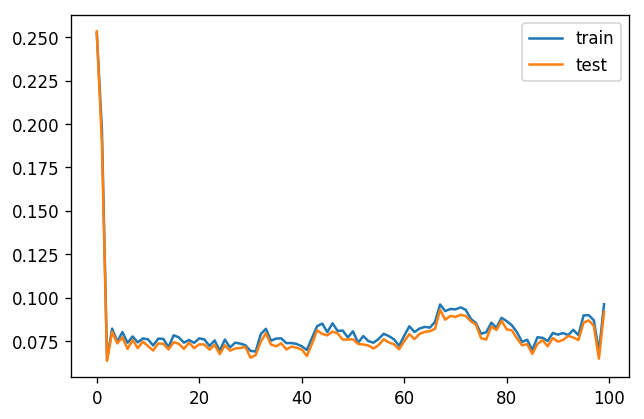

Test loss: 0.091809
Epoch 96, train loss: 0.079568
Epoch 97, train loss: 0.071913
Epoch 98, train loss: 0.076217
Epoch 99, train loss: 0.091003


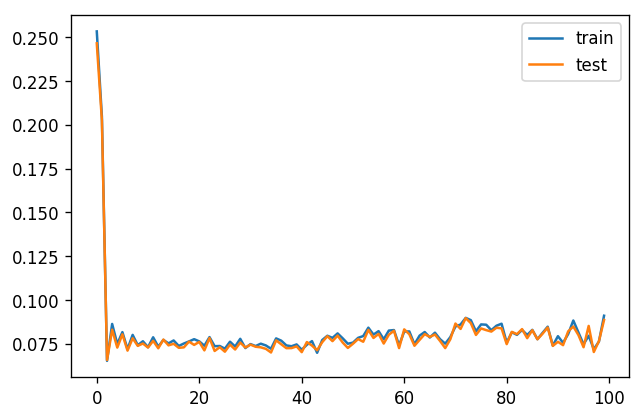

Test loss: 0.088561
5-fold validation: Avg train loss: 0.084123, Avg test loss: 0.085955


In [83]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

In [78]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    #get submisstion test_id
    # predict results
    sample_submission = pd.read_csv('./input/sample_submission.csv')

    test_id = sample_submission['Id']
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch, 
          learning_rate, weight_decay)
    preds = np.expm1(net(X_test).asnumpy()).ravel()
    mysubmission = pd.DataFrame({'Id':test_id,'SalePrice':preds})
    mysubmission.to_csv('./input/mysubmission_v5.csv',index= False)
#     test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
#     submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
#     submission.to_csv('submission.csv', index=False)

Epoch 96, train loss: 0.074627
Epoch 97, train loss: 0.075633
Epoch 98, train loss: 0.073627
Epoch 99, train loss: 0.075155


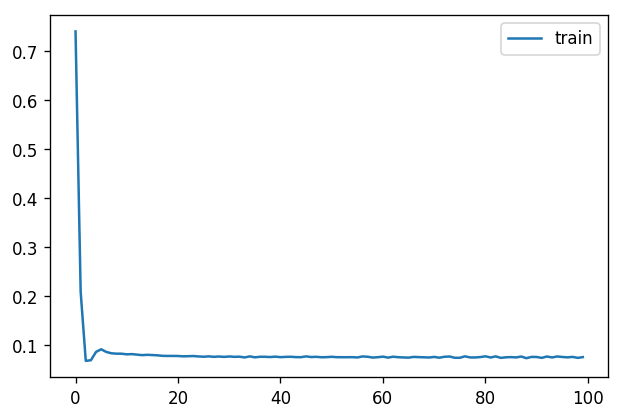

In [79]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)